# Analyse parameter sweep of QC network system (selective degradation)

To investigate the relationship between $Q$ and the fusion rate for some cost functions

Author: Juvid Aryaman

Date: 15/10/17

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import os
import re
from scipy.integrate import ode 
from matplotlib import cm
import matplotlib.ticker as ticker
import warnings 

from ipywidgets import interact

%reload_ext autoreload
%autoreload 2
%matplotlib inline
plt.close('all')
fontsize = 20
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)
font = {'size' : fontsize}
plt.rc('font', **font)
mpl.rc('lines', markersize=10)
plt.rcParams.update({'axes.labelsize': fontsize})
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{amsfonts}']	

In [2]:
warnings.simplefilter("ignore",UserWarning)

In [3]:
perturbed_params = pd.read_csv('../param_sweep_vals_SD.csv')

In [4]:
perturbed_params.head()

,h_init_mean,n_target,xi,beta,gamma,kappa,b,mu,delta,Q,net_rat
0,0.3,1000.0,0.0,33.12,0.000379,977.0,0.000012,0.023,1.0,1.000000,0.01
1,0.3,1000.0,0.0,33.12,0.000379,977.0,0.000012,0.023,1.0,1.000010,0.01
2,0.3,1000.0,0.0,33.12,0.000379,977.0,0.000012,0.023,1.0,1.000032,0.01
3,0.3,1000.0,0.0,33.12,0.000379,977.0,0.000012,0.023,1.0,1.000100,0.01
4,0.3,1000.0,0.0,33.12,0.000379,977.0,0.000012,0.023,1.0,1.000316,0.01


## Make heatmap of summary stats of interest

In [5]:
epsilon_space = np.linspace(-5,1,13)
eps_labels = [r'$\epsilon=0$']+list(epsilon_space)
eps_labels

['$\\epsilon=0$',
 -5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0]

In [6]:
n_points = 21

lg_ls_low_gamma = -2
lg_ls_high_gamma = 2

gamma_labels = np.linspace(lg_ls_low_gamma,lg_ls_high_gamma,n_points) # gamma space
gamma_labels

array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
        0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ])

In [7]:
h_cdf_4_array = np.zeros((21,14)) # P(h>0.4) at some time T
eh_array = np.zeros((21,14)) # E(h) at some time T
vh_array = np.zeros((21,14)) # E(h) at some time T
en_array = np.zeros((21,14)) # E(n) at some time T

efs_array = np.zeros((21,14)) # E(fs) at some time T

count_array = np.zeros((21,14)) # counts (for dbg)

kappa_array = np.zeros((21,14)) # counts (for dbg)
Q_array = np.zeros((21,14))

T_measure = 1000.0

for i in range(21): #gammas
    for j in range(14): #Qs
        param_try = 14*i+j
        
        kappa_array[i,j] = perturbed_params.loc[param_try]['kappa']
        Q_array[i,j] = perturbed_params.loc[param_try]['Q']
        
        xi, gamma, beta, kappa, b, mu, delta = perturbed_params.loc[param_try][['xi', 'gamma', 'beta', 'kappa', 'b', 'mu', 'delta']]

        stats_data = pd.read_csv('../Data/online_stats_{}.csv'.format(param_try))
        
        h_cdf_4_array[i,j] = 1.-stats_data[stats_data['t']==T_measure].cdf_h_0_4/stats_data[stats_data['t']==T_measure].counts
        eh_array[i,j] = stats_data[stats_data['t']==T_measure].mean_h
        vh_array[i,j] = stats_data[stats_data['t']==T_measure].var_h
        efs_array[i,j] = stats_data[stats_data['t']==T_measure].mean_fs
        
        en_array[i,j] = stats_data[stats_data['t']==T_measure].mean_n
        
        count_array[i,j] = stats_data.counts.sum()


In [8]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

### Summary stats

In [9]:
def cast_as_1sf_str(X):
    return ["%.1f" % x for x in X]

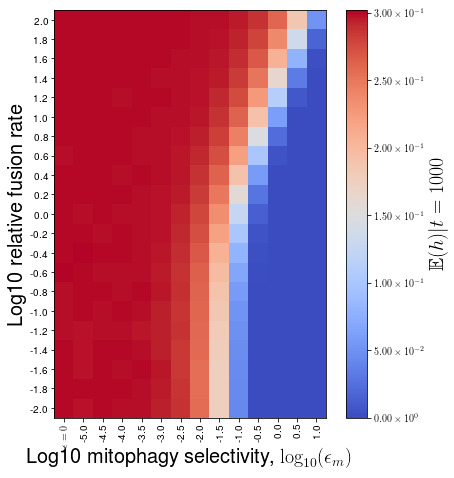

In [10]:
fig, ax = plt.subplots(1,1, figsize = (9,7.5))
im00 = ax.imshow(np.flipud(eh_array),cmap = cm.coolwarm, interpolation='none')
plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\mathbb{{E}}(h)|t={:d}$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))
ax.set_xlabel(r'Log10 mitophagy selectivity, $\log_{10}(\epsilon_m)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(14));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
plt.savefig('eh_sd.svg', bbox_inches='tight')

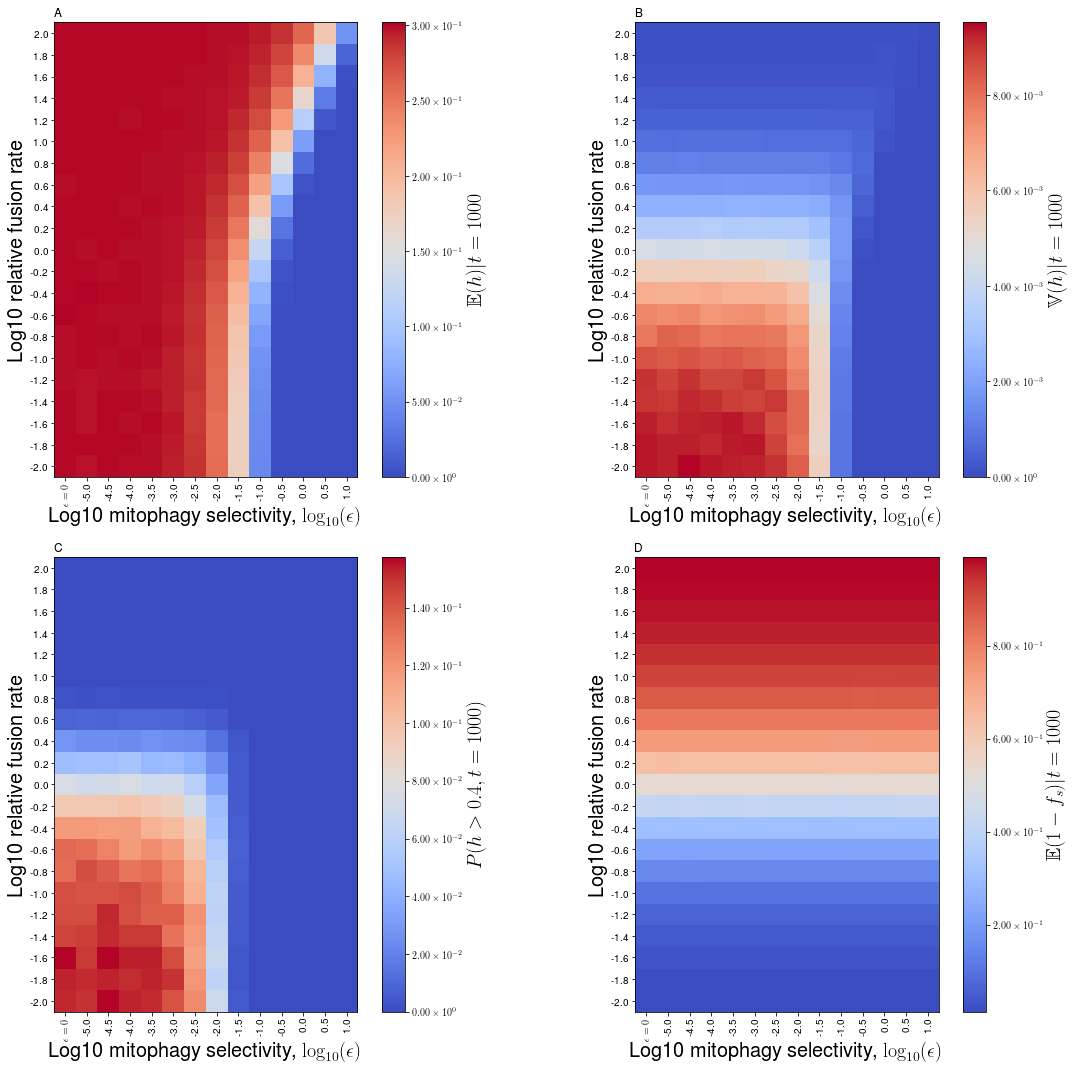

In [11]:
fig, axs = plt.subplots(2,2, figsize = (2*9,2*7.5))
axs = axs.ravel()

ax = axs[0]
im00 = ax.imshow(np.flipud(eh_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\mathbb{{E}}(h)|t={:d}$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 mitophagy selectivity, $\log_{10}(\epsilon)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(14));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
ax.set_title('A',loc='left')

ax = axs[1]
im00 = ax.imshow(np.flipud(vh_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\mathbb{{V}}(h)|t={:d}$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 mitophagy selectivity, $\log_{10}(\epsilon)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(14));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
ax.set_title('B',loc='left')


ax = axs[2]
im00 = ax.imshow(np.flipud(h_cdf_4_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$P(h>0.4,t={:d})$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 mitophagy selectivity, $\log_{10}(\epsilon)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(14));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
ax.set_title('C',loc='left')



ax = axs[3]
im00 = ax.imshow(np.flipud(1.-efs_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\mathbb{{E}}(1-f_s)|t={:d}$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 mitophagy selectivity, $\log_{10}(\epsilon)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(14));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
ax.set_title('D',loc='left')


plt.tight_layout()

#plt.savefig('Q_fs_sw_SD.pdf')

### Counts

In [12]:
count_array.shape

(21, 14)

In [13]:
count_array.min(),count_array.max()

(1010000.0, 1010000.0)

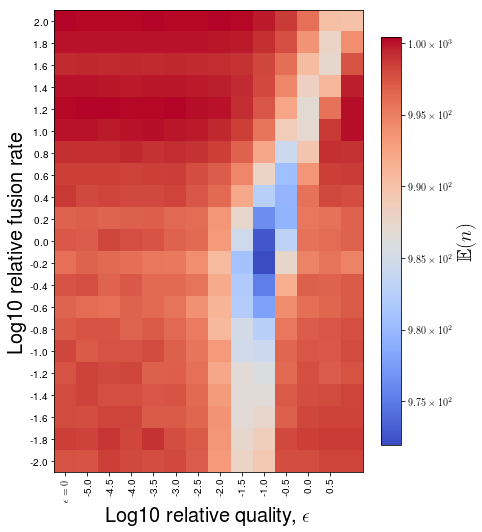

In [14]:
fig, ax = plt.subplots(1,1, figsize = (7.5,7.5))
#axs = axs.ravel()

#ax = axs[0]
im00 = ax.imshow(np.flipud(en_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\mathbb{E}(n)$",format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 relative quality, $\epsilon$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(13));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));


plt.tight_layout()

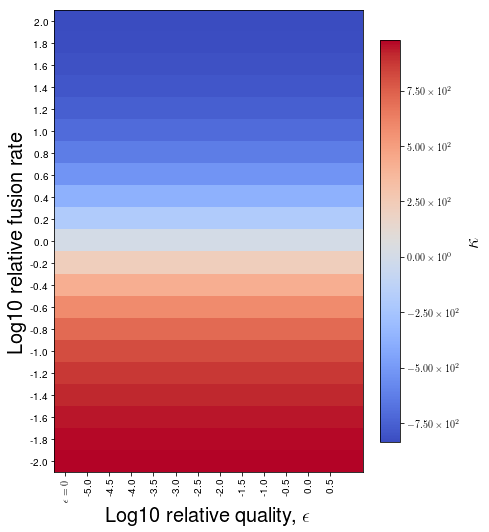

In [15]:
fig, ax = plt.subplots(1,1, figsize = (7.5,7.5))
#axs = axs.ravel()

#ax = axs[0]
im00 = ax.imshow(np.flipud(kappa_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\kappa$",format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 relative quality, $\epsilon$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(13));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));


plt.tight_layout()

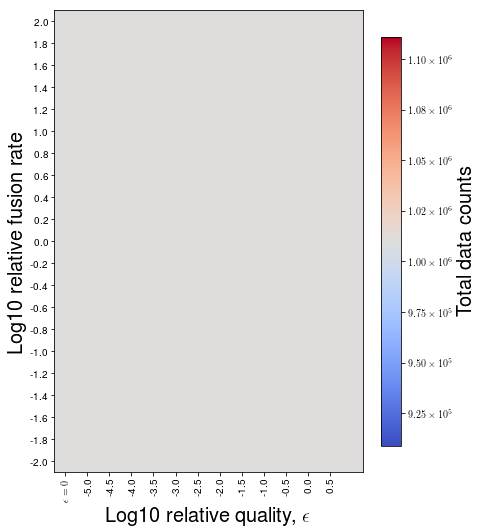

In [16]:
fig, ax = plt.subplots(1,1, figsize = (7.5,7.5))
#axs = axs.ravel()

#ax = axs[0]
im00 = ax.imshow(np.flipud(count_array),cmap = cm.coolwarm, interpolation='none')
                 #vmin = -2.2, vmax = -1.5)

plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="Total data counts",format=ticker.FuncFormatter(fmt))

ax.set_xlabel(r'Log10 relative quality, $\epsilon$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(13));
ax.set_yticks(range(21));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));


plt.tight_layout()